In [56]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pylab as plt

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TF version: 2.11.0
Hub version: 0.12.0
GPU is NOT AVAILABLE


In [57]:
ATTR_PATH = "C:/Users/Rostom/Videos/5SDBD/Projet_Intégrateur/archive/list_attr_celeba.csv"  # contains the image attributes (Male, Smiling, Young, ...)
PARTITION_PATH = "C:/Users/Rostom/Videos/5SDBD/Projet_Intégrateur/archive/list_eval_partition.csv"  # contains the recommended partitioning of images into training, validation and testing sets.
IMAGES_PATH = "C:/Users/Rostom/Videos/5SDBD/Projet_Intégrateur/archive/img_align_celeba/img_align_celeba/"  # contains the .jpg images

BATCH_SIZE = 128  # try a smaller batch size if you have limited computational resources
MODEL_HANDLE = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b0/feature_vector/2"  # we use this pretrained model to obtain a feature vector from each image
IMAGE_SIZE = (224, 224)  # input size required by our pretrained model

In [58]:
df = pd.merge(pd.read_csv(PARTITION_PATH), pd.read_csv(ATTR_PATH), on="image_id")
df.head()

,image_id,partition,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,0,-1,1,1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,0,-1,-1,-1,1,-1,-1,-1,1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,0,-1,-1,-1,-1,-1,-1,1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,0,-1,-1,1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,0,-1,1,1,-1,-1,-1,1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [59]:
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMAGE_SIZE)
    return image

def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)

def load_and_preprocess_from_path_label(path, male, smiling, young, attractive):
    images = load_and_preprocess_image(path)
    return images, male, smiling, young, attractive

def build_dataset_from_df(df):
    ds = tf.data.Dataset.from_tensor_slices((
        [IMAGES_PATH + image_id for image_id in df["image_id"]],
        list(df["Male"].replace(-1, 0)),
        list(df["Smiling"].replace(-1, 0)),
        list(df["Young"].replace(-1, 0)),
        list(df["attractive"].replace(-1, 0))
    ))
    ds = ds.map(load_and_preprocess_from_path_label)
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

In [60]:
train_df = df.loc[df["partition"] == 0].head(500)
# if you're in a rush, add: train_df = train_df.sample(n=5000)
train_ds = build_dataset_from_df(train_df)

val_df = df.loc[df["partition"] == 1].head(100)
# if you're in a rush, add: val_df = val_df.sample(n=1000)
val_ds = build_dataset_from_df(val_df)

In [61]:
for image, male, smiling, young, attractive in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label gender: ", male.shape)
    print("Label smiling: ", smiling.shape)
    print("Label young: ", young.shape)
    print("Label bald: ", attractive.shape)

Image shape:  (128, 224, 224, 3)
Label gender:  (128,)
Label smiling:  (128,)
Label young:  (128,)
Label attractive:  (128,)


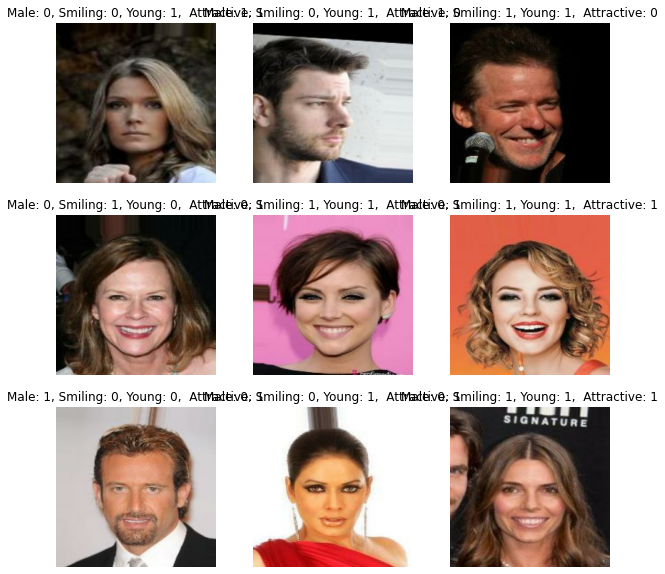

In [65]:
image, male, smiling, young, attractive = next(iter(train_ds))
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image[i].numpy().astype("uint8"))
    s = f"Male: {male[i].numpy()}, Smiling: {smiling[i].numpy()}, Young: {young[i].numpy()},  Attractive: {attractive[i].numpy()}"
    plt.title(s)
    plt.axis("off")

In [66]:
normalization_layer = tf.keras.layers.Rescaling(1. / 255)
preprocessing_model = tf.keras.Sequential([normalization_layer])
do_data_augmentation = False
if do_data_augmentation:
    preprocessing_model.add(tf.keras.layers.RandomRotation(0.2))
    preprocessing_model.add(tf.keras.layers.RandomTranslation(0, 0.2))
    preprocessing_model.add(tf.keras.layers.RandomTranslation(0.2, 0))
    preprocessing_model.add(tf.keras.layers.RandomZoom(0.2, 0.2))
    preprocessing_model.add(tf.keras.layers.RandomFlip(mode="horizontal"))
train_ds = train_ds.map(lambda images, male, smiling, young, attractive:
                        (preprocessing_model(images), (male, smiling, young, attractive)))

val_ds = val_ds.map(lambda images, male, smiling, young, attractive:
                    (normalization_layer(images), (male, smiling, young, attractive)))

In [67]:
do_fine_tuning = False
input = tf.keras.Input(shape=IMAGE_SIZE + (3,))
x = hub.KerasLayer(MODEL_HANDLE, trainable=do_fine_tuning)(input)
x = tf.keras.layers.Dropout(rate=0.2)(x)
x = tf.keras.layers.Dense(128, activation="relu")(x)

out_male = tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l2(0.0001), activation="sigmoid", name='male')(x)
out_smiling = tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l2(0.0001), activation="sigmoid", name='smiling')(x)
out_young = tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l2(0.0001), activation="sigmoid", name='young')(x)
out_attractive = tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l2(0.0001), activation="sigmoid", name='attractive')(x)


model = tf.keras.Model( inputs = input, outputs = [out_male, out_smiling, out_young, attractive])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 keras_layer_1 (KerasLayer)     (None, 1280)         5919312     ['input_2[0][0]']                
                                                                                                  
 dropout_1 (Dropout)            (None, 1280)         0           ['keras_layer_1[0][0]']          
                                                                                                  
 dense_1 (Dense)                (None, 128)          163968      ['dropout_1[0][0]']        

In [72]:
model.compile(
    loss = {
        "male": tf.keras.losses.BinaryCrossentropy(),
        "smiling": tf.keras.losses.BinaryCrossentropy(),
        "young": tf.keras.losses.BinaryCrossentropy(),
        "attractive": tf.keras.losses.BinaryCrossentropy()
    },
    metrics = {
        "male": 'accuracy',
        "smiling": 'accuracy',
        "young": 'accuracy',
        "attractive": 'accuracy'
    },
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
)

In [73]:
steps_per_epoch = len(train_df) // BATCH_SIZE
validation_steps = len(val_df) // BATCH_SIZE
hist = model.fit(
    train_ds,
    epochs=3, steps_per_epoch=steps_per_epoch,
    validation_data=val_ds,
    validation_steps=validation_steps).history

Epoch 1/3
3/3 [==============================] - 16s 3s/step - loss: 2.7793 - male_loss: 0.5809 - smiling_loss: 0.8976 - young_loss: 0.5601 - attractive_loss: 0.7400 - male_accuracy: 0.6849 - smiling_accuracy: 0.4688 - young_accuracy: 0.7552 - attractive_accuracy: 0.5859
Epoch 2/3
3/3 [==============================] - 9s 3s/step - loss: 2.0168 - male_loss: 0.2788 - smiling_loss: 0.6475 - young_loss: 0.4997 - attractive_loss: 0.5901 - male_accuracy: 0.9219 - smiling_accuracy: 0.6094 - young_accuracy: 0.7708 - attractive_accuracy: 0.6849
Epoch 3/3
3/3 [==============================] - 9s 3s/step - loss: 1.8084 - male_loss: 0.2106 - smiling_loss: 0.6010 - young_loss: 0.4427 - attractive_loss: 0.5533 - male_accuracy: 0.9271 - smiling_accuracy: 0.6771 - young_accuracy: 0.8047 - attractive_accuracy: 0.7266


KeyError: 'val_male_loss'

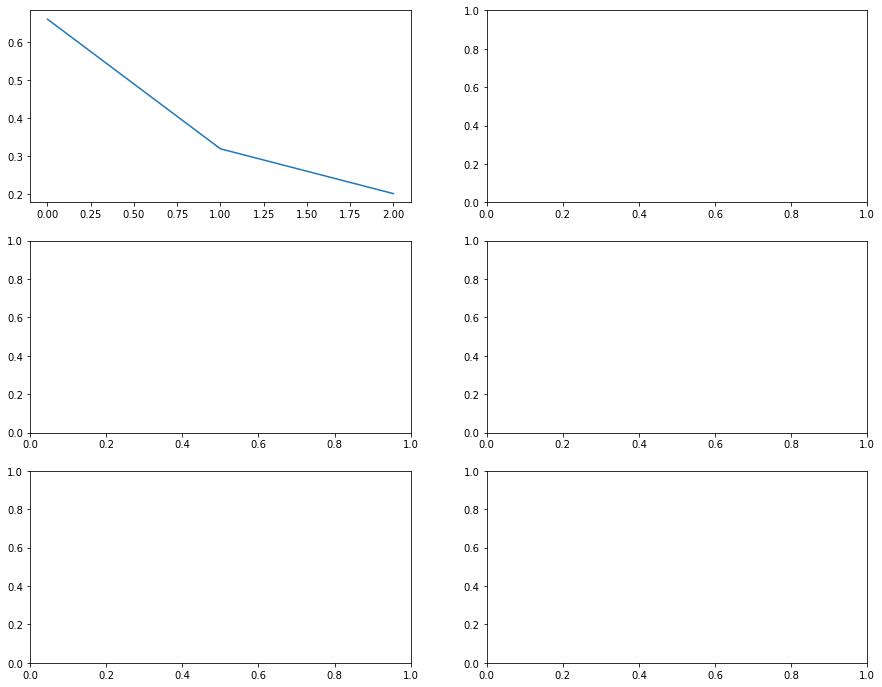

In [12]:
fig, ax = plt.subplots(3, 2, figsize=(15, 12))
for i, c in enumerate(["male", "smiling", "young"]):
    ax[i, 0].plot(hist[f"{c}_loss"], label="train")
    ax[i, 0].plot(hist[f"val_{c}_loss"], label="val")
    ax[i, 0].set_title(f"Loss ({c})")
    ax[i, 0].legend()
    ax[i, 1].plot(hist[f"{c}_accuracy"], label="train")
    ax[i, 1].plot(hist[f"val_{c}_accuracy"], label="val")
    ax[i, 1].set_title(f"Accuracy ({c})")
    ax[i, 1].legend()
plt.show()

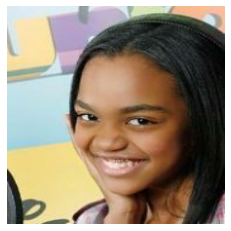

1/1 [==============================] - 0s 95ms/step
Male: actual 1, predicted 0 (0.1083)
Smiling: actual 0, predicted 1 (0.8731)
Young: actual 1, predicted 1 (0.8505)
Attractive: actual 0, predicted 1 (0.7639)


In [81]:
x, y = next(iter(val_ds))
image = x[2, :, :, :]
plt.imshow(image)
plt.axis('off')
plt.show()

prediction_scores = model.predict(np.expand_dims(image, axis=0))
for i, label in enumerate(["Male", "Smiling", "Young", "Attractive"]):
    pred = prediction_scores[i][0][0]
    print(f"{label}: actual {y[i][0]}, predicted {1 if pred > 0.5 else 0} ({format(pred, '.4f')})")

In [26]:
from keras.utils import plot_model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 keras_layer (KerasLayer)       (None, 1280)         5919312     ['input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 1280)         0           ['keras_layer[0][0]']            
                                                                                                  
 dense (Dense)                  (None, 128)          163968      ['dropout[0][0]']            